## Radial Heat Transport

This example was originally published in Al-Khoury et al 2020. The original data by Al-Khoury et al. (2020) was for a radially symmetric finite-element mesh.  Where their mesh calculates values at mesh points, this setup uses those points as vertices in a DISV grid.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import math

In [2]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwe-radial"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [3]:
# Scenario-specific parameters.  Other scenarios are described in Al-Khoury et al 2020
parameters = {
    "ex-gwe-radial-slow-b": {
        "gwvelocity": 1e-5,
        "dirichlet": 0.0,
        "neumann": 100.0,
    },
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods in flow model ($-$)
nlay = 1  # Number of layers ($-$)
simrad = 20  # Simulation radius ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
top = 1.0  # Top of the model ($m$)
botm = 0.0  # Bottom of the model ($m$)
prsity = 0.2  # Porosity ($-$)
perlen = 2  # Length of simulation ($days$)
strt_temp = 0.0  # Initial Temperature ($^{\circ} C$)
scheme = "TVD"  # Advection solution scheme ($-$)
ktw = 0.56  # Thermal conductivity of water ($\frac{W}{m \cdot ^{\circ} C}$)
kts = 2.50  # Thermal conductivity of aquifer material ($\frac{W}{m \cdot ^{\circ} C}$)
rhow = 1000.0  # Density of water ($kg/m^3$)
cpw = 4180.0  # Heat capacity of water ($\frac{J}{kg \cdot ^{\circ} C}$)
rhos = 2650.0  # Density of dry solid aquifer material ($kg/m^3$)
cps = 900.0  # Heat capacity of dry solid aquifer material ($\frac{J}{kg \cdot ^{\circ} C}$)
al = 0.0  # Mechanical dispersion ($m^2/day$)
ath1 = 0.0  # Transverse dispersivity ($m^2/day$)
strt = 1.0  # Starting head ($m$)
v1 = 1.0e-5  # Groundwater seepage velocity 1 ($m/s$)

In [4]:
# Convert Kts and Ktw units to use days
ktw = ktw * 86400
kts = kts * 86400

In [5]:
# Convert Watts (=J/sec) to J/days
unitadj = 86400

In [6]:
# Set some static flow model parameters
laytyp = 1
nstp = 48
icelltype = 0  # Cell conversion type (0: Cell thickness will be held constant)
lhv = 2500.0  # Latent heat of vaporization (will eventually need to be removed)

In [7]:
# Load a file stored in the data directory for building out the DISV grid
fname = "Qin100_V1e-5.csv"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/develop/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:2f45f4f50998964e49c6e0337973c6ac",
)

In [8]:
# Set up some global lists that will be set in the GWF setup but
# also needed in the GWE simulation
verts = []
cell2d = []
chd_iverts = []
bore_ivert = []
left_x = None
right_x = None
left_chd_spd_slow = None
right_chd_spd_slow = None
left_chd_spd_fast = None
right_chd_spd_fast = None

In [9]:
# ### Solver Parameters

nouter = 1000
ninner = 100
hclose = 1e-9
rclose = 1e-6
relax = 1.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [10]:
# Static temporal data used by TDIS file Simulation has 1 steady stress period (1 day).
perlen = [perlen]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Functions for building the DISV mesh


def generate_starting_vert_lst(basedata):
    verts = []
    for index, row in basedata.iterrows():
        verts.append([int(row["vertid"]), row["X"], row["Y"]])

    return verts


def handle_small_differences_in_radi(radi_lst):
    lvl = []
    i = 0
    for ct, num in enumerate(radi_lst[1]):
        if num == 180:
            lvl.append([i] * num)
            i += 1
            tally = 0
        else:
            lvl.append([i] * num)
            tally += 1
            if tally > 1:
                tally = 0
                i += 1

    flat_list = [item for sublist in lvl for item in sublist]

    return flat_list


def create_outer_ring_of_ctrl_vols(outer_v, verts, iverts, xc, yc, ivt, idx):
    left_chd_spd_slow = []
    left_chd_spd_fast = []
    right_chd_spd_slow = []
    right_chd_spd_fast = []

    # For each outer point, create a new ivert
    # Starts at 9 o'clock and proceeds counter-clockwise
    # As such, 'pt3' will be used by the subsequent iverts
    # However, 'pt4' will be re-used by each subseqeuent ivert
    pt3_id = pt3_rad = pt3_ang = None
    for ii in np.arange(len(outer_v) - 1):
        # Create all the points involved
        pt1 = outer_v.iloc[ii]
        pt2 = outer_v.iloc[ii + 1]

        if ii == 0:
            pt4_rad, pt4_ang = round(pt1["radius"] + 0.025, 2), pt1["ang"]

            # If the first time through the loop, save the newly created point because
            # it is needed at end of the loop
            pt4_id = idx + 2
            finish_id = pt4_id
            finish_rad = pt4_rad
            finish_ang = pt4_ang

        else:
            assert pt3_id is not None
            assert pt3_rad is not None
            assert pt3_ang is not None
            pt4_id = pt3_id
            pt4_rad = pt3_rad
            pt4_ang = pt3_ang

        # pt3 needs to come after storing previous values as pt4
        # If last ivert on the outer loop, special handling
        if ii == (len(outer_v) - 2):
            pt3_id = finish_id
            pt3_rad = finish_rad
            pt3_ang = finish_ang
        else:
            pt3_id, pt3_rad, pt3_ang = (
                idx + 1,
                round(pt2["radius"] + 0.025, 2),
                pt2["ang"],
            )

        # Create a subset of vertices for the new outer chd ivert
        subverts = [int(pt1["vertid"]), int(pt2["vertid"]), pt3_id, pt4_id]

        pt3_x = pt3_rad * math.cos(pt3_ang)
        pt3_y = pt3_rad * math.sin(pt3_ang)
        pt4_x = pt4_rad * math.cos(pt4_ang)
        pt4_y = pt4_rad * math.sin(pt4_ang)

        subvertx = [pt1["X"], pt2["X"], pt3_x, pt4_x]
        subverty = [pt1["Y"], pt2["Y"], pt3_y, pt4_y]

        # Store the new vertices in the main collection of "verts"
        # If not the last lap in FOR loop
        if ii != (len(outer_v) - 2):
            idx += 1
            verts.append([idx, pt3_x, pt3_y])

        # If the first time through, store new point
        if ii == 0:
            idx += 1
            verts.append([idx, pt4_x, pt4_y])

        ivt += 1
        if flopy.utils.geometry.is_clockwise(subvertx, subverty):
            iverts.append([ivt] + subverts)
        else:
            iverts.append([ivt] + subverts[::-1])

        # Calculate the means, since it is at this location where the chd
        # boundary will be applied
        mean_x = np.array(subvertx).mean()
        mean_y = np.array(subverty).mean()
        xc.append(mean_x)
        yc.append(mean_y)

        # Determine where on the constant head continuum the current point lies
        q1 = v1 * 86400 * prsity
        chd_val_slow = strt + q1 * Lx - ((mean_x + abs(left_x)) / Lx) * q1 * Lx

        # Store the constant head boundary information
        if mean_x < 0:
            left_chd_spd_slow.append([0, ivt, chd_val_slow, 0.0])
        elif mean_x > 0:
            right_chd_spd_slow.append([0, ivt, chd_val_slow, 0.0])

    return left_chd_spd_slow, right_chd_spd_slow, ivt, idx


def scooch_cell_center(xcoll, ycoll):
    xtemp = np.array(xcoll).mean()
    ytemp = np.array(ycoll).mean()
    ang = math.atan2(ytemp, xtemp)
    radius = math.sqrt(xtemp**2 + ytemp**2)
    radius += 0.0001
    xnew = math.cos(ang) * radius
    ynew = math.sin(ang) * radius

    return xnew, ynew


def generate_control_volumes(basedata, verts, flat_list, idx):
    global left_x, right_x, Lx
    ivt = -1
    iverts = []
    xc, yc = [], []

    # Loop for each radius level
    for i, (r1, r2) in enumerate(
        zip(np.unique(flat_list)[0:-1], np.unique(flat_list)[1:])
    ):
        curr_rad = basedata[basedata["grp"] == r1]
        next_rad = basedata[basedata["grp"] == r2]

        # It is imperative that within each radius grouping, values are sorted
        # in ascending order by angle
        curr_rad = curr_rad.sort_values(["ang"], ascending=True)
        next_rad = next_rad.sort_values(["ang"], ascending=True)

        # Repeat the first set of values at the end of the list for closing
        # the loop
        new_row = pd.DataFrame(
            {
                curr_rad.columns[0]: int(curr_rad.iloc[0].iloc[0]),
                curr_rad.columns[1]: float(curr_rad.iloc[0].iloc[1]),
                curr_rad.columns[2]: float(curr_rad.iloc[0].iloc[2]),
                curr_rad.columns[3]: float(curr_rad.iloc[0].iloc[3]),
                curr_rad.columns[4]: float(curr_rad.iloc[0].iloc[4]),
                curr_rad.columns[7]: int(curr_rad.iloc[0].iloc[7]),
            },
            index=[0],
        )
        curr_rad = pd.concat([curr_rad, new_row], ignore_index=True)

        another_new_row = pd.DataFrame(
            {
                next_rad.columns[0]: int(next_rad.iloc[0].iloc[0]),
                next_rad.columns[1]: float(next_rad.iloc[0].iloc[1]),
                next_rad.columns[2]: float(next_rad.iloc[0].iloc[2]),
                next_rad.columns[3]: float(next_rad.iloc[0].iloc[3]),
                next_rad.columns[4]: float(next_rad.iloc[0].iloc[4]),
                next_rad.columns[7]: int(next_rad.iloc[0].iloc[7]),
            },
            index=[0],
        )
        next_rad = pd.concat([next_rad, another_new_row], ignore_index=True)

        # All the points in the first set of points constitute the well bore
        if i == 0:
            subverts = []
            subvertx = []
            subverty = []
            # Do not iterate over the last row since it is a duplicate
            for ct, row in curr_rad.iloc[:-1].iterrows():
                subverts.append(int(row["vertid"]))
                subvertx.append(float(row["X"]))
                subverty.append(float(row["Y"]))

            xc.append(round(np.array(subvertx).mean(), 4))
            yc.append(round(np.array(subverty).mean(), 4))

            ivt += 1
            if flopy.utils.geometry.is_clockwise(subvertx, subverty):
                iverts.append([ivt] + subverts)
            else:
                iverts.append([ivt] + subverts[::-1])

        # Using the 'looped' data above, do 1 lap around the data to generate iverts
        for rw in np.arange(len(curr_rad) - 1):
            n1_id = int(curr_rad.iloc[rw + 1]["vertid"])
            n2_id = int(next_rad.iloc[rw + 1]["vertid"])
            n3_id = int(next_rad.iloc[rw]["vertid"])
            n4_id = int(curr_rad.iloc[rw]["vertid"])

            n1_x = float(curr_rad.iloc[rw + 1]["X"])
            n2_x = float(next_rad.iloc[rw + 1]["X"])
            n3_x = float(next_rad.iloc[rw]["X"])
            n4_x = float(curr_rad.iloc[rw]["X"])

            n1_y = float(curr_rad.iloc[rw + 1]["Y"])
            n2_y = float(next_rad.iloc[rw + 1]["Y"])
            n3_y = float(next_rad.iloc[rw]["Y"])
            n4_y = float(curr_rad.iloc[rw]["Y"])

            subverts = [n1_id, n2_id, n3_id, n4_id]
            subvertx = [n1_x, n2_x, n3_x, n4_x]
            subverty = [n1_y, n2_y, n3_y, n4_y]

            if i == 0:
                # For the case i==0, need to have the centroid of the control
                # volume almost touching the well bore. Find out which 2 of
                # the 4 pts are closest to the well
                bndpts = [id for id in subverts if id in iverts[0]]
                # collect the pts in a list for further processing
                xcoll = []
                ycoll = []
                for id in bndpts:
                    for num, xchk in enumerate(subverts):
                        if xchk == id:
                            xcoll.append(subvertx[num])
                            ycoll.append(subverty[num])
                assert (
                    len(xcoll) == 2
                ), "Should only be two points touching the well bore"

                # was getting divide by zero error in MF6 when putting the
                # centroid right on the line connecting the two points that
                # touch the well bore, so moving the new point just a bit
                # further away from the origin (which is the center of the
                # well bore)
                xnew, ynew = scooch_cell_center(xcoll, ycoll)
                xc.append(xnew)
                yc.append(ynew)
            else:
                xc.append(np.array(subvertx).mean())
                yc.append(np.array(subverty).mean())

            ivt += 1
            if flopy.utils.geometry.is_clockwise(subvertx, subverty):
                iverts.append([ivt] + subverts)
            else:
                iverts.append([ivt] + subverts[::-1])

        print("Working on radius level " + str(i))

    # After the function call above, an outer ring of control volumes with constant
    # heads needs to be added. For the constant head boundary, we want a
    # gradient that results in v=1e-5 m/sec (or 1e-4)
    left_x = np.min(next_rad["X"]) - (0.025 / 2)
    right_x = np.max(next_rad["X"]) + (0.025 / 2)
    Lx = abs(right_x - left_x)

    # Work up the outer-most control volumes (iverts)
    (
        left_chd_spd_slow,
        right_chd_spd_slow,
        ivt,
        idx,
    ) = create_outer_ring_of_ctrl_vols(next_rad, verts, iverts, xc, yc, ivt, idx)

    return (
        ivt,
        iverts,
        xc,
        yc,
        left_chd_spd_slow,
        right_chd_spd_slow,
        left_chd_spd_fast,
        right_chd_spd_fast,
    )


def build_cell2d_obj(iverts, xc, yc):
    # Build and return the cell2d object needed by the disv instantiator
    cell2d = []
    for i, itm in enumerate(iverts):
        itm_no = itm[0]
        cell2d.append([itm_no, xc[i], yc[i], len(iverts[i][1:])] + iverts[i][1:])

    return cell2d


def remove_euclidian_duplicates(pd_with_dupes):
    # Set a threshold to filter out
    thresh = 0.001
    distances = np.sqrt(
        np.sum(
            [
                (pd_with_dupes[[c]].to_numpy() - pd_with_dupes[c].to_numpy()) ** 2
                for c in ("X", "Y")
            ],
            axis=0,
        )
    )
    msk = np.tril(distances < thresh, k=-1).any(axis=1)
    out = pd_with_dupes[~msk]

    return out


def create_divs_objs(fl):
    # Read the FE mesh data:
    radat = pd.read_csv(fl, header=None, names=["X", "Y", "Temp"])

    # Some spatial processing from radial info to X, Y info
    radat["radius"] = (radat["X"].values ** 2 + radat["Y"].values ** 2) ** 0.5
    radat["radius_rounded"] = round(radat["radius"], 4)
    radat["ang"] = np.arctan2(radat["Y"].values, radat["X"].values)

    # Initial screening: There were some duplicates in the original data that
    # Mehdi shared
    radat.drop_duplicates(subset=["X", "Y"], inplace=True)

    # But even the above doesn't seem to get all of the duplicates
    radat = remove_euclidian_duplicates(radat)

    # Sort dataframe based on 1) radius and then on 2) angle
    radat.sort_values(["radius_rounded", "ang"], ascending=True, inplace=True)

    # Reindex after dropping duplicated rows
    radat.reset_index(inplace=True)

    # Add the index as a regular column (this will serve as the vertex ID)
    radat["vertid"] = radat.index.tolist()

    # Create initial list of verts from shared base data
    verts = generate_starting_vert_lst(radat)

    # Since 'verts' will be added to, setup a counter
    idx = len(verts)
    idx -= 1  # convert to 0-based

    # Get list of unique radi.  It is on the basis of each vertex's radius from
    # the center that the iverts (control volumes) will be setup.
    radi = np.unique(radat["radius_rounded"], return_counts=True)

    # Owing to a slight shift in some of the middle radi, for example 0.1312
    # and 0.1313, need to do some special handling.
    flat_list = handle_small_differences_in_radi(radi)
    radat["grp"] = flat_list

    # Setup the iverts based on the vertices
    # Returns the index, initial list of control volumes (iverts)
    # and lists of the mean locations of the iverts
    (
        ivt,
        iverts,
        xc,
        yc,
        left_chd_spd_slow,
        right_chd_spd_slow,
        left_chd_spd_fast,
        right_chd_spd_fast,
    ) = generate_control_volumes(radat, verts, flat_list, idx)

    # Create the cell2d object
    cell2d = build_cell2d_obj(iverts, xc, yc)

    # Return objects for DISV
    return (
        verts,
        cell2d,
        left_chd_spd_slow,
        right_chd_spd_slow,
        left_chd_spd_fast,
        right_chd_spd_fast,
    )


def build_mf6_flow_model(sim_name, left_chd_spd=None, right_chd_spd=None, silent=True):
    gwfname = "gwf-" + sim_name.split("-")[2]
    sim_ws = os.path.join(workspace, sim_name, "mf6gwf")

    # Instantiate a new MF6 simulation
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="Simple",
        no_ptcrecord="all",
        linear_acceleration="bicgstab",
        scaling_method="NONE",
        reordering_method="NONE",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        under_relaxation="dbd",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        rcloserecord="{} strict".format(rclose),
        filename="{}.ims".format(sim_name),
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nogrb=False,
        ncpl=len(cell2d),
        nvert=len(verts),
        nlay=nlay,
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV",
        filename="{}.disv".format(gwfname),
    )

    # Instantiating MODFLOW 6 node property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        xt3doptions="XT3D",
        k=k11,
        save_specific_discharge=True,
        save_saturation=True,
        pname="NPF",
        filename="{}.npf".format(gwfname),
    )

    # Instatiating MODFLOW 6 initial conditions package
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    # Instantiating MODFLOW 6 storage package
    # (steady flow conditions, so no actual storage,
    # using to print values in .lst file)
    flopy.mf6.ModflowGwfsto(
        gwf,
        ss=0,
        sy=0,
        steady_state={0: True},
        pname="STO",
        filename="{}.sto".format(gwfname),
    )

    # Instantiating 1st instance of MODFLOW 6 constant head package (left side)
    # (setting auxiliary temperature to 0.0)
    left_chd_spd = {0: left_chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        auxiliary="TEMPERATURE",
        stress_period_data=left_chd_spd,
        pname="CHD-LEFT",
        filename="{}.left.chd".format(sim_name),
    )

    right_chd_spd = {0: right_chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        auxiliary="TEMPERATURE",
        stress_period_data=right_chd_spd,
        pname="CHD-RIGHT",
        filename="{}.right.chd".format(sim_name),
    )

    # Instantiating MODFLOW 6 output control package (flow model)
    head_filerecord = "{}.hds".format(sim_name)
    budget_filerecord = "{}.cbc".format(sim_name)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    return sim


def build_mf6_heat_model(
    sim_name,
    scen_ext,
    dirichlet=0.0,
    neumann=0.0,
    gwvelocity=0.0,
    silent=False,
):
    print("Building mf6gwt model...{}".format(sim_name))
    gwename = "gwe-" + sim_name.split("-")[2]
    sim_ws = os.path.join(workspace, sim_name[:-2], "mf6gwe" + scen_ext)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 groundwater transport model
    gwe = flopy.mf6.MFModel(
        sim,
        model_type="gwe6",
        modelname=gwename,
        model_nam_file="{}.nam".format(gwename),
    )

    # Create iterative model solution and register the gwe model with it
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="SIMPLE",
        no_ptcrecord="all",
        linear_acceleration="bicgstab",
        scaling_method="NONE",
        reordering_method="NONE",
        outer_maximum=nouter,
        outer_dvclose=hclose * 1000,
        under_relaxation="dbd",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_maximum=ninner,
        inner_dvclose=hclose * 1000,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        rcloserecord="{} strict".format(rclose),
        filename="{}.ims".format(gwename),
    )
    sim.register_ims_package(imsgwe, [gwe.name])

    # MF6 time discretization differs from corresponding flow simulation
    tdis_rc = []
    # Run combination of 1/2-hourly and hourly stress periods
    for tm in np.arange(48):  # 48 1/2 hr time steps (1st day)
        if tm < 8:
            tdis_rc.append((1 / 48, 10, 1.0))  # Should result in 5 minute time steps
        elif tm < 48:
            tdis_rc.append((1 / 48, 1, 1.0))  # Should result in 30 minute time steps
        else:
            break

    # Add time discretization for the 2nd day
    for tm in np.arange(4):  # 24 hourly time steps (2nd day)
        tdis_rc.append((1 / 4, 1, 1.0))

    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_rc), perioddata=tdis_rc, time_units=time_units
    )

    # Instantiating MODFLOW 6 heat transport discretization package
    flopy.mf6.ModflowGwedisv(
        gwe,
        nlay=nlay,
        ncpl=len(cell2d),
        nvert=len(verts),
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV-GWE",
        filename="{}.disv".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport initial temperature
    flopy.mf6.ModflowGweic(gwe, strt=strt_temp, filename="{}.ic".format(gwename))

    # Instantiating MODFLOW 6 heat transport advection package
    flopy.mf6.ModflowGweadv(gwe, scheme=scheme, filename="{}.adv".format(gwename))

    # Instantiating MODFLOW 6 heat transport dispersion package
    if ktw != 0:
        flopy.mf6.ModflowGwecnd(
            gwe,
            alh=al,
            ath1=ath1,
            ktw=ktw,
            kts=kts,
            pname="CND",
            filename="{}.cnd".format(gwename),
        )

    # Instantiating MODFLOW 6 heat transport mass storage package (consider renaming to est)
    flopy.mf6.ModflowGweest(
        gwe,
        porosity=prsity,
        cps=cps,
        rhos=rhos,
        packagedata=[cpw, rhow, lhv],
        pname="EST",
        filename="{}.est".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport constant temperature package (Dirichlet case)
    if dirichlet > 0 and neumann == 0.0:
        # The first item in the ivert list is the well bore control volume.
        # As such, we can easily specify the constant temperature information
        ctpspd = {0: [0, 0, dirichlet]}

        flopy.mf6.ModflowGwectp(
            gwe,
            maxbound=len(ctpspd),
            stress_period_data=ctpspd,
            save_flows=False,
            pname="CTP-1",
            filename="{}.ctp".format(gwename),
        )

    if neumann > 0 and dirichlet == 0:
        # Remember that the well bore is in the first index of ivert,
        # so we can specify layer 0, ID=0
        esl_spd = {0: [0, 0, neumann * unitadj]}

        flopy.mf6.ModflowGweesl(
            gwe,
            maxbound=len(esl_spd),
            stress_period_data=esl_spd,
            save_flows=False,
            pname="ESL-1",
            filename="{}.esl".format(gwename),
        )

    # Instantiating MODFLOW 6 source/sink mixing package for dealing with
    # auxiliary temperature specified in constant head boundary package.
    sourcerecarray = [
        ("CHD-LEFT", "AUX", "TEMPERATURE"),
        ("CHD-RIGHT", "AUX", "TEMPERATURE"),
    ]
    flopy.mf6.ModflowGwessm(
        gwe, sources=sourcerecarray, filename="{}.ssm".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport output control package
    flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord="{}.cbc".format(gwename),
        temperature_filerecord="{}.ucn".format(gwename),
        temperatureprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord={47: [("TEMPERATURE", "LAST"), ("BUDGET", "LAST")]},
        printrecord=[("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 Flow-Model Interface package
    pd = [
        ("GWFHEAD", "../mf6gwf/" + sim_name[:-2] + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/" + sim_name[:-2] + ".cbc", None),
    ]
    flopy.mf6.ModflowGwefmi(gwe, packagedata=pd)

    return sim


def write_mf6_models(sim_mf6gwe, sim_mf6gwf=None, silent=True):
    if sim_mf6gwf is not None:
        sim_mf6gwf.write_simulation(silent=silent)

    sim_mf6gwe.write_simulation(silent=silent)


@timed
def run_model(sim, silent=True):
    success = True
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [11]:
def plot_grid(sim):
    with styles.USGSPlot():
        simname = sim.name
        gwf = sim.get_model("gwf-" + simname.split("-")[2])

        figure_size = (5, 5)
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")

        # plot up the cellid numbers with regard to
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid(lw=0.4)

        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("X position (m)")
        ax.set_ylabel("Y position (m)")
        styles.heading(ax, heading="Radial DISV Grid", idx=0)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}-grid{}".format(simname, ".png")
            fig.savefig(fpth, dpi=300)


def plot_grid_inset(sim):
    with styles.USGSPlot():
        simname = sim.name
        gwf = sim.get_model("gwf-" + simname.split("-")[2])

        figure_size = (5, 5)
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")

        # plot up the cellid numbers with regard to
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid(lw=0.4)

        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("X position (m)")
        ax.set_ylabel("Y position (m)")
        ax.set_xlim([-0.15, 0.20])
        ax.set_ylim([-0.05, 0.3])

        styles.heading(ax, heading="Radial DISV Grid", idx=1)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}-gridinset{}".format(simname, ".png")
            fig.savefig(fpth, dpi=300)


def plot_head(sim):
    figure_size = (5, 5)

    simname = sim.name
    gwf = sim.get_model("gwf-" + simname.split("-")[2])
    head = gwf.output.head().get_data()[:, 0, :]

    with styles.USGSPlot():
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

        cb = pmv.plot_array(head, cmap="jet")
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, heading="Simulated Head", idx=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}-head{}".format(simname, ".png")
            fig.savefig(fpth, dpi=300)


def plot_temperature(sim, idx, scen_txt, vel_txt):
    figure_size = (5, 5)

    # Get analytical solution
    simname = sim.name[:13]
    adat = pd.read_csv(
        fpath,
        delimiter=",",
        header=None,
        names=["x", "y", "temp"],
    )
    gwe = sim.get_model("gwe-" + simname.split("-")[2])

    with styles.USGSPlot():
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        temp = (
            gwe.output.temperature().get_alldata()
        )  # eventually restore to: .temperature().
        temp48h = temp[
            -1
        ]  # Plot the temperature at 48 hours, same as analytical solution provided
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwe, ax=ax, layer=0)

        levels = [1, 2, 3, 4, 6, 8]
        cmap = plt.cm.jet  # .plasma

        # extract discrete colors from the .plasma map
        cmaplist = [cmap(i) for i in np.linspace(0, 1, len(levels))]

        cs1 = pmv.contour_array(temp48h, levels=levels, colors=cmaplist, linewidths=0.5)
        labels = ax.clabel(
            cs1,
            cs1.levels,
            inline=False,
            inline_spacing=0.0,
            fontsize=8,
            fmt="%1d",
        )
        cs2 = ax.tricontour(
            adat["x"],
            adat["y"],
            adat["temp"],
            linewidths=0.5,
            colors=cmaplist,
            levels=levels,
            linestyles="dashed",
        )

        for label in labels:
            label.set_bbox(dict(facecolor="white", pad=1, ec="none"))

        bhe = plt.Circle((0.0, 0.0), 0.075, fc=(1, 0, 0, 0.4), ec=(0, 0, 0, 1), lw=2)
        ax.add_patch(bhe)
        ax.text(0.0, 0.0, "BHE", ha="center", va="center")
        ax.text(
            0.2,
            -0.80,
            "Groundwater flow direction",
            ha="center",
            va="center",
            fontsize=8,
        )
        arr = mpatches.FancyArrowPatch(
            (0.6, -0.80),
            (0.8, -0.80),
            arrowstyle="->,head_width=.15",
            mutation_scale=20,
        )
        ax.add_patch(arr)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        ax.set_xlim([-0.65, 1.5])
        ax.set_ylim([-1, 1])
        styles.heading(ax, heading=" Simulated Temperature at 48 hours", idx=3)

        # save figure
        if plot_show:
            plt.show()
        if plot_save:
            fname = sim.name
            fpth = figs_path / "{}-temp48{}".format(sim_name, ".png")
            fig.savefig(fpth, dpi=300)


# Generates 4 figures
def plot_results(idx, sim_mf6gwf, sim_mf6gwe, silent=True):
    plot_grid(sim_mf6gwf)
    plot_grid_inset(sim_mf6gwf)
    plot_head(sim_mf6gwf)

    scen = "Qin100"
    vel_txt = "1e-5"

    # Temperature is plotted at 48 hours
    plot_temperature(sim_mf6gwe, idx, scen_txt=scen, vel_txt=vel_txt)

### Running the example

Define a function to run the example scenarios and plot results.

In [12]:
def scenario(idx, silent=False):
    # Two different sets of values used among the 4 scenarios, but fastest to calculate them all at the same time
    global verts, cell2d
    global top, botm
    global left_chd_spd_slow, right_chd_spd_slow
    global left_chd_spd_fast, right_chd_spd_fast

    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]

    # The following takes about 30 seconds, but only needs to be run once
    # fl = os.path.join("..", "data", "ex-gwe-radial", "Qin100_V1e-5.csv")
    (
        verts,
        cell2d,
        left_chd_spd_slow,
        right_chd_spd_slow,
        left_chd_spd_fast,
        right_chd_spd_fast,
    ) = create_divs_objs(fpath)

    top = np.ones((len(cell2d),))
    botm = np.zeros((1, len(cell2d)))

    # Pass the constant head value based to set the scenario's velocity
    left_chd_spd = left_chd_spd_slow
    right_chd_spd = right_chd_spd_slow

    scen_ext = key[-2:]

    # Build the flow model as a steady-state simulation
    sim_mf6gwf = build_mf6_flow_model(
        key[:-2],
        left_chd_spd=left_chd_spd,
        right_chd_spd=right_chd_spd,
        silent=silent,
    )

    # Run the transport model as a transient simulation, requires reading the
    # steady-state flow output saved in binary files.
    sim_mf6gwe = build_mf6_heat_model(key, scen_ext, **parameter_dict, silent=silent)
    if write:
        write_mf6_models(sim_mf6gwe, sim_mf6gwf=sim_mf6gwf, silent=silent)
    if run:
        if sim_mf6gwf is not None:
            run_model(sim_mf6gwf, silent)
        run_model(sim_mf6gwe, silent)
    if plot:
        plot_results(idx, sim_mf6gwf, sim_mf6gwe)

Run the scenario.

Working on radius level 0
Working on radius level 1
Working on radius level 2


Working on radius level 3
Working on radius level 4
Working on radius level 5


Working on radius level 6
Working on radius level 7


Working on radius level 8
Working on radius level 9


Working on radius level 10
Working on radius level 11


Working on radius level 12
Working on radius level 13
Working on radius level 14


Working on radius level 15
Working on radius level 16


Working on radius level 17
Working on radius level 18
Working on radius level 19


Working on radius level 20
Working on radius level 21
Working on radius level 22


Working on radius level 23
Working on radius level 24
Working on radius level 25


Working on radius level 26
Working on radius level 27


Working on radius level 28
Working on radius level 29
Working on radius level 30


Working on radius level 31
Working on radius level 32
Working on radius level 33


Working on radius level 34
Working on radius level 35
Working on radius level 36


Working on radius level 37
Working on radius level 38
Working on radius level 39


Working on radius level 40
Working on radius level 41
Working on radius level 42


Working on radius level 43
Working on radius level 44


Working on radius level 45
Working on radius level 46
Working on radius level 47


Working on radius level 48
Working on radius level 49
Working on radius level 50


Working on radius level 51
Working on radius level 52
Working on radius level 53


Working on radius level 54
Working on radius level 55
Working on radius level 56


Working on radius level 57
Working on radius level 58
Working on radius level 59


Working on radius level 60
Working on radius level 61
Working on radius level 62


Working on radius level 63
Working on radius level 64
Working on radius level 65


Working on radius level 66
Working on radius level 67
Working on radius level 68


Working on radius level 69
Working on radius level 70
Working on radius level 71


Working on radius level 72
Working on radius level 73


Working on radius level 74
Working on radius level 75
Working on radius level 76


Working on radius level 77
Working on radius level 78
Working on radius level 79


Working on radius level 80
Working on radius level 81
Working on radius level 82


Working on radius level 83
Working on radius level 84
Working on radius level 85


Working on radius level 86
Working on radius level 87


Working on radius level 88
Working on radius level 89
Working on radius level 90


Working on radius level 91
Working on radius level 92
Working on radius level 93


Working on radius level 94
Working on radius level 95


Working on radius level 96
Working on radius level 97


Working on radius level 98
Working on radius level 99
Working on radius level 100


Working on radius level 101
Working on radius level 102
Working on radius level 103


Working on radius level 104
Working on radius level 105
Working on radius level 106


Working on radius level 107
Working on radius level 108
Working on radius level 109


Building mf6gwt model...ex-gwe-radial-slow-b


run_model took 764.51 ms


run_model took 26865.70 ms


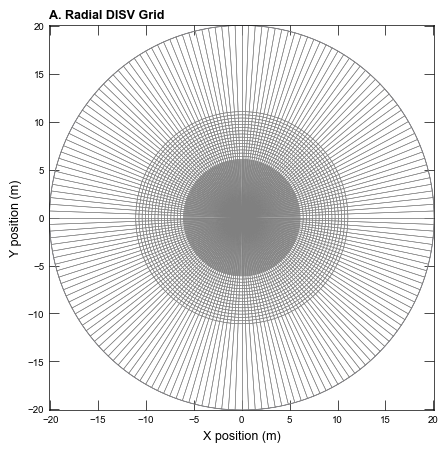

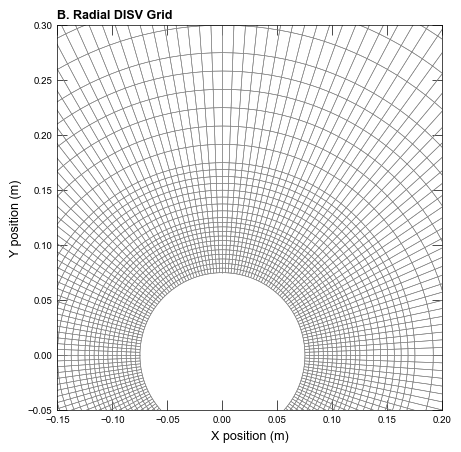

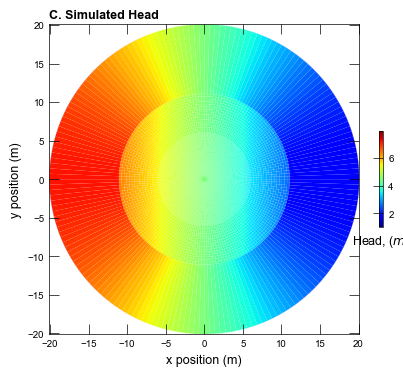

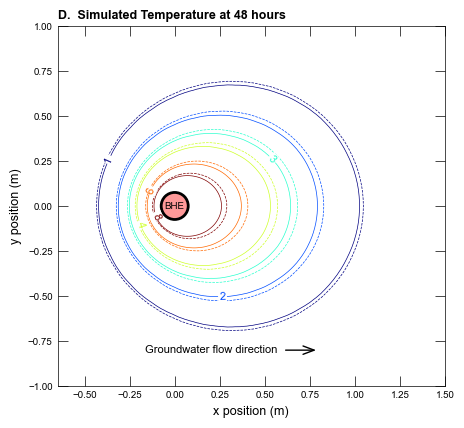

In [13]:
scenario(0, silent=True)